<a href="https://colab.research.google.com/github/KartikGarg20526/Emoji-Prediction-using-twitter-data/blob/main/Emoji_detection_ML_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
from textblob import TextBlob
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [47]:
tweet_txt_raw = open('/content/us_train.text','r',encoding="utf8")
tweet_labels_raw = open('/content/us_train.labels','r',encoding="utf8")

tweet_text = []
tweet_labels = []

for sentence in tweet_txt_raw:
    sentence = sentence.rstrip()
    tweet_text.append(sentence)

for sentence in tweet_labels_raw:
    sentence = sentence.rstrip()
    sentence = int(sentence)
    tweet_labels.append(sentence)

df = pd.DataFrame()
df["Tweet"] = tweet_text
df["Label"] = tweet_labels

In [48]:
df.head()

,Tweet,Label
0,A little throwback with my favourite person @ ...,0
1,glam on @user yesterday for #kcon makeup using...,7
2,Democracy Plaza in the wake of a stunning outc...,11
3,Then &amp; Now. VILO @ Walt Disney Magic Kingdom,0
4,Who never... @ A Galaxy Far Far Away,2


In [49]:
print("Shape of the dataset : ", df.shape)

Shape of the dataset :  (50000, 2)


# Emoji Mapping

In [50]:
emoji_raw = open('/content/us_mapping.txt','r',encoding="utf8")

emoji = []
label = []
meaning = []
for sentence in emoji_raw:
    print(sentence)
    sentence = sentence.rstrip()
    label.append(sentence.split()[0])
    emoji.append(sentence.split()[1])
    meaning.append(sentence.split()[2:])

emoji_map = pd.DataFrame()
emoji_map['Label'] = label
emoji_map['Emoji'] = emoji
emoji_map['Meaning'] = meaning

0	❤️	 Red heart	

1	😍	 Smiling face with hearteyes	

2	😂	 Face with tears of joy	

3	💕	 Two hearts

4	🔥	 Fire

5	😊	 Smiling face with smiling eyes	

6	😎	 Smiling face with sunglasses	

7	✨	 Sparkles 	

8	💙	 Blue heart

9	😘	 Face blowing a kiss	

10	📷	 Camera	

11	🇺🇸	 United States	

12	☀️	 Sun

13	💜	 Purple heart 	

14	😉	 Winking face	

15	💯	 Hundred points	

16	😁	 Beaming face with smiling eyes	

17	🎄	Christmas tree	

18	📸	Camera with flash

19	😜	Winking face with tongue	



In [51]:
print(emoji_map)

   Label Emoji                               Meaning
0      0    ❤️                          [Red, heart]
1      1     😍      [Smiling, face, with, hearteyes]
2      2     😂          [Face, with, tears, of, joy]
3      3     💕                         [Two, hearts]
4      4     🔥                                [Fire]
5      5     😊  [Smiling, face, with, smiling, eyes]
6      6     😎     [Smiling, face, with, sunglasses]
7      7     ✨                            [Sparkles]
8      8     💙                         [Blue, heart]
9      9     😘              [Face, blowing, a, kiss]
10    10     📷                              [Camera]
11    11    🇺🇸                      [United, States]
12    12    ☀️                                 [Sun]
13    13     💜                       [Purple, heart]
14    14     😉                       [Winking, face]
15    15     💯                     [Hundred, points]
16    16     😁  [Beaming, face, with, smiling, eyes]
17    17     🎄                     [Christmas,

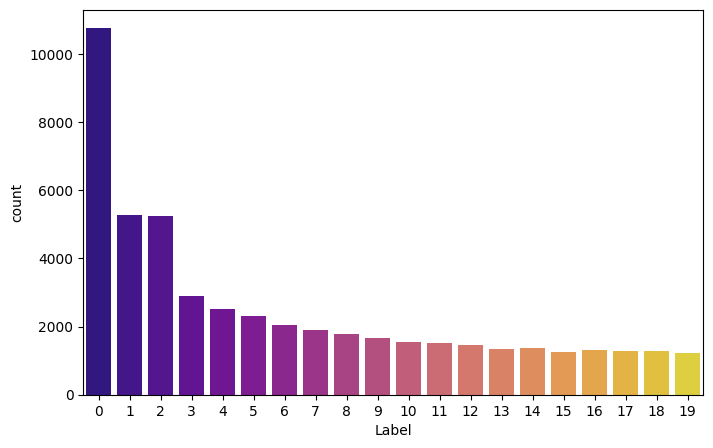

In [52]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['Label'], palette="plasma")
plt.show()

In [53]:
# Checking for NULL values
df['Label'].isnull().sum()

0

In [54]:
# Checking if our data has duplicated rows
print("Duplicated Rows : ", df.duplicated().sum())

Duplicated Rows :  116


In [55]:
# Dropping duplicated rows
df = df.drop_duplicates()

In [56]:
# Reseting the indexes after dropping some rows
df = df.reset_index(drop=True)

In [57]:
print("Shape of the data : ", df.shape)

Shape of the data :  (49884, 2)


Checking of there is some correlation between tweet length and Label data

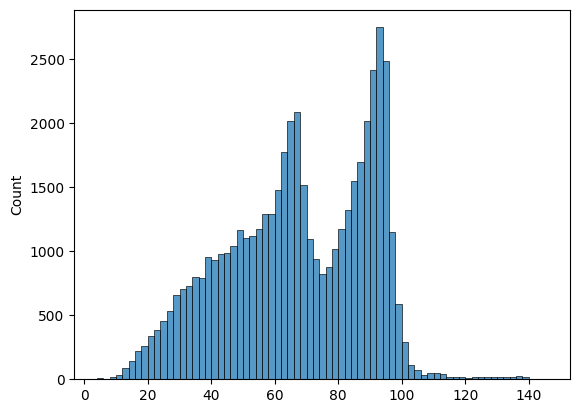

In [58]:
tweet_len = []
for sen in df['Tweet']:
  tweet_len.append(len(sen))

new_df = pd.DataFrame()
new_df['Tweet_Length'] = tweet_len

sns.histplot(tweet_len)
plt.show()

In [59]:
corr = df['Label'].corr(new_df['Tweet_Length'])
print("Correlation between tweet length and label : ", corr)

Correlation between tweet length and label :  0.023448833195926666


Correlation between Tweet length and Label is very low.

# Preprocessing

In [60]:
def lowercase(tweet):
  tweet = str(tweet)
  return tweet.lower()

In [61]:
def remove_html_tags(tweet):
    tweet = str(tweet)
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', tweet)

In [62]:
def remove_url(tweet):
    tweet = str(tweet)
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', tweet)

In [63]:
def remove_punctuations(tweet):
    tweet = str(tweet)
    exclude = string.punctuation
    return tweet.translate(str.maketrans('', '', exclude))

In [64]:
def remove_mentions(tweet):
    return re.sub(r'@[A-Za-z0-9_]+', '', tweet)

In [65]:
def remove_stopwords(tweet):
    tweet = str(tweet)
    tweet_words = []

    for word in tweet.split():
        if word in stopwords.words('english'):
            tweet_words.append('')
        else:
            tweet_words.append(word)
    return ' '.join(tweet_words)

In [66]:
def remove_numbers(tweet):
    tweet = str(tweet)
    return re.sub(r'\d+', '', tweet)

In [67]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for w in word_tokenize(text):
        lemmatized_words.append(lemmatizer.lemmatize(w))
    return " ".join(lemmatized_words)

In [68]:
def preprocessing(data):
  df['Tweet'] = df['Tweet'].apply(lowercase)            # converting to lowercase
  df['Tweet'] = df['Tweet'].apply(remove_html_tags)     # removing html tags
  df['Tweet'] = df['Tweet'].apply(remove_url)           # removing Urls
  df['Tweet'] = df['Tweet'].apply(remove_punctuations)  # removing punctutations
  df['Tweet'] = df['Tweet'].apply(remove_mentions)      # removing @ mentions
  df['Tweet'] = df['Tweet'].apply(remove_stopwords)     # removing stopwords
  df['Tweet'] = df['Tweet'].apply(remove_numbers)       # removing numbers
  df['Tweet'] = df['Tweet'].apply(lemmatize_text)       # applying lemmatization

In [69]:
preprocessing(df)

In [70]:
df.head()

,Tweet,Label
0,little throwback favourite person water wall,0
1,glam user yesterday kcon makeup using user fea...,7
2,democracy plaza wake stunning outcome decision...,11
3,amp vilo walt disney magic kingdom,0
4,never galaxy far far away,2


# Sentiment Analysis

In [71]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
analyzer = SentimentIntensityAnalyzer()
sentiment_score = []
for tweet in df['Tweet']:
  sentiment = analyzer.polarity_scores(tweet)['compound']
  if sentiment >= 0.5:
    sentiment_score.append(1)
  elif sentiment <= -0.5:
    sentiment_score.append(-1)
  else:
    sentiment_score.append(0)

print(sentiment_score)

In [73]:
new_df = pd.DataFrame()
new_df['Tweet'] = df['Tweet']
new_df['Sentiment_Score'] = sentiment_score
new_df['Label'] = df['Label']
print(new_df.shape)

(49884, 3)


In [74]:
new_df.sample(5)

,Tweet,Sentiment_Score,Label
40808,forever grateful moment pure happiness brought...,1,3
20949,wife user amazing line work one favorite x amp...,1,1
41950,youre coming back know youre coming back plis ...,0,2
34099,igersusa old town alexandria,0,6
17764,think time bring raykay backlet dancing begin ...,0,14


In [75]:
corr = new_df['Label'].corr(new_df['Sentiment_Score'])

In [76]:
print("Correlation between Sentiment of the tweet and label : ", corr)

Correlation between Sentiment of the tweet and label :  -0.06495911462472476


Correlation between sentiment of the tweet and label is very low so we will discard it as our feature.

In [77]:
X = df['Tweet'].values
y = df['Label'].values

# Over-sampling data

In [78]:
df['Label'].value_counts()

0     10728
1      5263
2      5237
3      2881
4      2513
5      2312
6      2043
7      1884
8      1791
9      1667
10     1541
11     1518
12     1460
14     1375
13     1346
16     1306
18     1284
17     1276
15     1246
19     1213
Name: Label, dtype: int64

In [79]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler()
X = X.reshape(X.shape[0],1)
X, y = os.fit_resample(X, y)
X = X.reshape(X.shape[0],)
print(X.shape, y.shape)

(214560,) (214560,)


# Count Vectorization

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
bow = cv.fit_transform(X)

In [81]:
bow.shape

(214560, 55352)

In [82]:
print("Number of unique words : ", bow[0].shape[1])

Number of unique words :  55352


In [83]:
cv.get_feature_names_out()[:50]

array(['aa', 'aaa', 'aaaaahhhh', 'aaaaand', 'aaaah', 'aaaand', 'aaaannnd',
       'aaah', 'aaahhh', 'aaand', 'aaatrirace', 'aagl', 'aaja', 'aamhaz',
       'aampd', 'aampm', 'aampmcollege', 'aampt', 'aamufootball',
       'aandbgethitched', 'aap', 'aarch', 'aaron', 'aaronjudge',
       'aaronransley', 'aarontequila', 'aassc', 'ab', 'aba', 'abandoned',
       'abandonedplaces', 'abandoner', 'abbey', 'abbileahair', 'abbot',
       'abbotkinney', 'abby', 'abbydamstra', 'abbys', 'abbyykaitlyn',
       'abc', 'abcalysha', 'abcd', 'abcs', 'abdalian', 'abdofela',
       'abdofeusa', 'abdulazizalrwaily', 'abe', 'abel'], dtype=object)

In [84]:
for i in range(2):
  print("Tweet : ", X[i])
  print("Vectorization of tweet : ", bow[i].toarray())

Tweet :  little throwback favourite person water wall
Vectorization of tweet :  [[0 0 0 ... 0 0 0]]
Tweet :  glam user yesterday kcon makeup using user featherette…
Vectorization of tweet :  [[0 0 0 ... 0 0 0]]


# Train Test Split

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bow, y, test_size=0.2, random_state=42)
print("Training X Dim ",X_train.shape)
print("Training y Dim ",y_train.shape)
print("Test X Dim ",X_test.shape)
print("Test y Dim ",y_test.shape)

Training X Dim  (171648, 55352)
Training y Dim  (171648,)
Test X Dim  (42912, 55352)
Test y Dim  (42912,)


# Support Vector Machines Model

In [86]:
from sklearn.svm import SVC

SVM = SVC()
SVM.fit(X_train, y_train)

SVC()

# Model Evaluation

In [87]:
y_pred = SVM.predict(X_test)

In [88]:
y_pred.shape

(42912,)

In [91]:
from sklearn.metrics import accuracy_score
print("Accuracy : ", accuracy_score(y_test,y_pred))

Accuracy :  0.9220031692766593


In [89]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55      2100
           1       0.80      0.70      0.74      2090
           2       0.79      0.81      0.80      2178
           3       0.91      0.88      0.90      2158
           4       0.94      0.94      0.94      2072
           5       0.94      0.91      0.92      2141
           6       0.94      0.93      0.94      2117
           7       0.95      0.95      0.95      2171
           8       0.96      0.94      0.95      2156
           9       0.96      0.96      0.96      2198
          10       0.97      0.98      0.98      2112
          11       0.94      0.98      0.96      2167
          12       0.90      0.99      0.94      2066
          13       0.99      0.98      0.98      2134
          14       0.99      0.98      0.98      2146
          15       0.98      0.98      0.98      2259
          16       0.98      0.99      0.99      2197
          17       0.95    

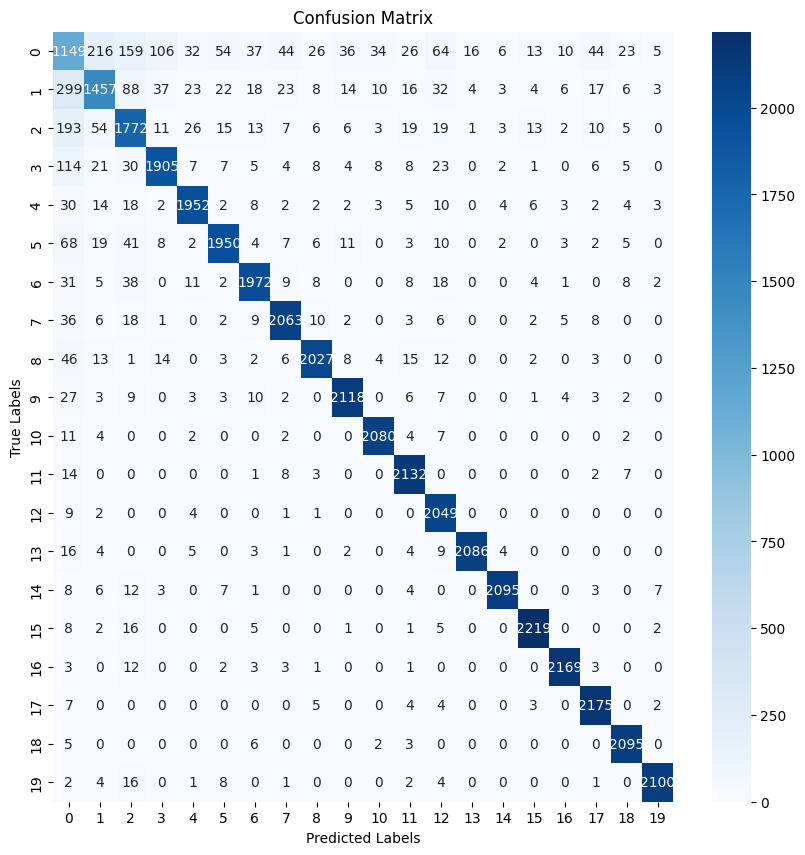

In [90]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[i for i in range(20)], yticklabels=[i for i in range(20)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()